In [4]:
from __future__ import annotations
import numpy as np
import pandas as pd
from scipy.stats import gamma
import seaborn as sns
import umap
import pprint
import matplotlib.pyplot as plt
import networkx as nx
from typing import Optional, Dict, Tuple, List, Union
from sklearn import set_config
import matplotlib.cm as cm
set_config(display="diagram")   # 再び図表示を有効化（1.4 系なら安全）



In [5]:
__all__ = [
    "generate_weight_matrix",
    "simulate_network",
]

### 遺伝子の数と重みに関わるマトリクスの作成

In [6]:
def generate_weight_matrix(
    n_genes: int = 10,
    shape: float = 2.0,
    scale: float = 1.0,
    allow_self_loop: bool = False,
    sparsity: float = 0.2,  # ← 80%がゼロ
    random_state: Optional[int] = None,
) -> np.ndarray:
    rng = np.random.default_rng(random_state)
    W = rng.gamma(shape, scale, size=(n_genes, n_genes))
    sign = rng.choice([-1.0, 1.0], size=(n_genes, n_genes))
    W *= sign

    # スパース化
    mask = rng.random((n_genes, n_genes)) > sparsity
    W *= mask

    if not allow_self_loop:
        np.fill_diagonal(W, 0.0)
    return W


In [7]:
_DEF_BETA = 4.0

def _sigmoid(x: np.ndarray, beta: float = _DEF_BETA) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-beta * x))


### 重みに基づいて初期発現・摂動をシミュレーションしたtrajectryの取得

In [8]:
def simulate_network(
    W: np.ndarray,
    *,
    perturb_gene: Optional[int] = None,
    perturb_value: float = 1.0,
    n_steps: int = 2000,
    dt: float = 0.05,
    noise_std: float = 0.05,
    beta: float = _DEF_BETA,
    threshold: float = 0.5,
    n_runs: int = 1000,
    random_state: Optional[int] = None,
    return_states: bool = False,
    return_trajectories: bool = False,
) -> Union[
    Dict[Tuple[int, ...], float],
    Tuple[Dict[Tuple[int, ...], float], List[Tuple[int, ...]]],
    Tuple[Dict[Tuple[int, ...], float], List[Tuple[int, ...]], List[np.ndarray]],
]:
    rng = np.random.default_rng(random_state)
    n_genes = W.shape[0]

    counts: Dict[Tuple[int, ...], int] = {}
    states: List[Tuple[int, ...]] = [] if return_states else None  # type: ignore
    trajectories: List[np.ndarray] = [] if return_trajectories else None  # type: ignore

    for _ in range(n_runs):
        x = rng.random(n_genes)  # initial expression 0–1
        if perturb_gene is not None:
            x[perturb_gene] = np.clip(x[perturb_gene] + perturb_value, 0.0, 1.0)

        if return_trajectories:
            traj = np.zeros((n_steps, n_genes))

        for t in range(n_steps):
            dx = -x + _sigmoid(W @ x, beta)
            x += dt * dx + noise_std * np.sqrt(dt) * rng.standard_normal(n_genes)
            x = np.clip(x, 0.0, 1.0)
            if return_trajectories:
                traj[t] = x

        bin_state: Tuple[int, ...] = tuple((x > threshold).astype(int))
        counts[bin_state] = counts.get(bin_state, 0) + 1
        if return_states:
            states.append(bin_state)  # type: ignore[arg-type]
        if return_trajectories:
            trajectories.append(traj)

    total = float(n_runs)
    probs = {state: c / total for state, c in counts.items()}

    if return_states and return_trajectories:
        return probs, states, trajectories
    elif return_states:
        return probs, states
    elif return_trajectories:
        return probs, trajectories
    else:
        return probs


In [9]:
def plot_expression_heatmap(final_states: np.ndarray, title: str = "Final Expression State per Run"):
    """
    final_states: np.ndarray of shape (n_runs, n_genes)
    title: plot title
    """
    plt.figure(figsize=(20, 6))
    sns.heatmap(final_states, cmap="viridis", cbar=True)

    plt.title(title, fontsize=14)
    plt.xlabel("Gene", fontsize=12)
    plt.ylabel("Run", fontsize=12)

    # Y軸（Runインデックス）ラベルを90度回転
    plt.yticks(rotation=360)
    plt.tight_layout()
    plt.show()

### 一つの細胞状態からKO/OE/摂動変化を適用してステップ数分細胞とtrajectryを返す関数

In [10]:
def simulate_perturbation(x0, W, pert_gene, mode="KO", n_steps=30, beta=4.0):
    """
    x0 : 初期発現ベクトル (連続値 0-1)
    pert_gene : 摂動対象の gene ID
    mode : "KO" (0 に固定) / "OE" (1 に固定) / "delta" (+0.5 など)
    """
    x = x0.copy()
    if mode == "KO":
        x[pert_gene] = 0.0
    elif mode == "OE":
        x[pert_gene] = 1.0
    elif isinstance(mode, (float, int)):     # delta
        x[pert_gene] = np.clip(x[pert_gene] + mode, 0, 1)

    traj = np.zeros((n_steps, len(x)))
    for t in range(n_steps):
        x = step_update(x, W, beta)
        traj[t] = x
    return traj

In [11]:
def step_update(x, W, beta=4.0):
    """1 ステップ更新: sigmoid(Wx) を Euler–Maruyama の決定項に対応させる"""
    return 1.0 / (1.0 + np.exp(-beta * (W @ x)))

### KO/OEで取得した値のコサイン類似度を取得

In [12]:
def perturbation_score(pos, vel, traj_emb):
    """
    pos, vel : 基準ベクトル場 (UMAP 2D に射影済み)
    traj_emb : 摂動軌跡を同じ UMAP で射影した 2D 座標配列
    """
    v_ref = (pos[1:] - pos[:-1]).mean(0)
    v_sim = traj_emb[-1] - traj_emb[0]
    return np.dot(v_ref, v_sim) / (np.linalg.norm(v_ref)*np.linalg.norm(v_sim))

### 重み付き遺伝子発現制御ネットワークの学習モデル(目的変数: 標的遺伝子の発現量、説明変数: そのほかの遺伝子の発現量)

In [13]:
import numpy as np
from numpy.random import default_rng
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import BaggingRegressor
from scipy.stats import t
def learn_grn_ridge_bagging(X_expr: np.ndarray,
                            alpha_grid=None,
                            n_estimators: int = 80,
                            cv: int = 5):
    """
    Bagging(Ridge) による GRN 推定
    ------------------------------------------------------------
    return:
        W_hat : (genes, genes)   … 平均係数
        Pval  : (genes, genes)   … ブートストラップ t 検定の P 値
    """
    n_cells, n_genes = X_expr.shape
    if alpha_grid is None:
        alpha_grid = np.logspace(-2, 2, 8)

    W_hat = np.zeros((n_genes, n_genes))
    Pval  = np.ones_like(W_hat)

    for tgt in range(n_genes):
        mask = np.ones(n_genes, bool); mask[tgt] = False
        X_tf, y = X_expr[:, mask], X_expr[:, tgt]

        # ① α を RidgeCV で最適化
        alpha_opt = RidgeCV(alphas=alpha_grid, cv=cv).fit(X_tf, y).alpha_

        # ② BaggingRegressor(base=Ridge(alpha_opt)) を学習
        base = Ridge(alpha=alpha_opt, fit_intercept=True)
        bag  = BaggingRegressor(estimator=base,
                                n_estimators=n_estimators,
                                bootstrap=True,
                                random_state=0).fit(X_tf, y)

        # ③ 各エスティメータの係数をスタックして統計量を計算
        coefs = np.vstack([est.coef_ for est in bag.estimators_])  # (n_est, n_TF)
        beta_mean = coefs.mean(axis=0)
        beta_se   = coefs.std(axis=0, ddof=1)
        tvals     = np.divide(np.abs(beta_mean), beta_se,
                              out=np.zeros_like(beta_mean), where=beta_se!=0)
        pvals     = 2*(1 - t.cdf(tvals, df=n_estimators-1))

        # ④ 出力行列へ書き込み
        W_hat[tgt, mask] = beta_mean
        Pval [tgt, mask] = pvals

    return W_hat, Pval

In [14]:
# ★ Cell 3 ── propagate と simulate_perturbation 定義 ★
def sigmoid(z, beta=4.0):
    return 1 / (1 + np.exp(-beta * z))

def propagate(x, W, beta=4.0):
    return np.clip(sigmoid(W @ x, beta), 0, 1)                # 1 step

def simulate_perturbation(x0, W, g, mode="KO", n_steps=30, beta=4.0):
    x = x0.copy()
    if mode == "KO":  x[g] = 0.0
    elif mode == "OE": x[g] = 1.0
    else:             x[g] = np.clip(x[g] + mode, 0, 1)

    traj = np.zeros((n_steps+1, len(x)))
    traj[0] = x                                              # step 0
    for t in range(1, n_steps+1):
        x = propagate(x, W, beta)                            # 下流へ伝播
        traj[t] = x
    return traj     

## Generate a random weight matrix

Weight matrix:
 [[-2.09181727 -0.         -0.          1.64507042  0.         -1.75337354
  -2.34600508  0.          3.07741359  0.        ]
 [ 3.79558385  0.         -0.         -0.          0.          0.
  -0.          0.81277693 -2.82212535  0.56580366]
 [ 0.94667552 -1.8218915  -3.06379062 -2.70575901  0.          0.
  -1.13018268 -1.3360964   0.78014998 -0.30137816]
 [-0.         -2.76379198  1.25578429  0.         -0.50266276  0.
   1.85738208 -0.          2.6117788   2.32864297]
 [-1.24052934 -0.55046145  1.13114983  2.36753463 -2.68170571  0.
   0.29953879 -0.47585799  2.23787909 -1.2245784 ]
 [ 1.2477426  -0.72857239 -0.71644203  0.         -2.29276523  1.01127648
  -1.76153045  1.98545782  4.70768776  0.66376046]
 [-1.96711948 -2.9939697   4.35942502  0.9696665   1.21237564 -2.62846619
   0.39767373 -2.10505901 -5.80179977  2.26095375]
 [-0.15137741  0.82204223 -0.99476141 -3.45636287 -1.47014378  0.30477054
   1.59819342  1.84057093  0.          0.70539973]
 [ 0.          3

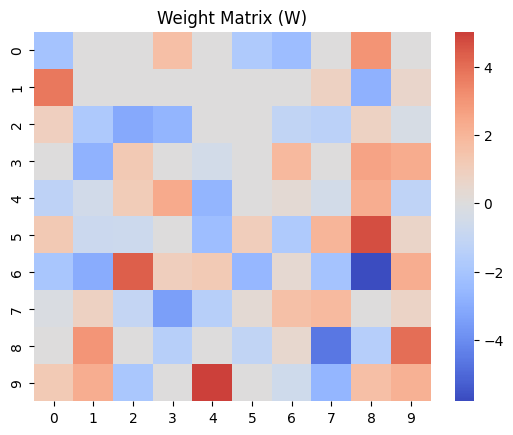

In [15]:
W = generate_weight_matrix(n_genes=10, random_state=42,sparsity=0.2,allow_self_loop=True)
print("Weight matrix:\n", W)
sns.heatmap(W, cmap='coolwarm', center=0)
plt.title("Weight Matrix (W)")
plt.show()

In [16]:
probs, states, trajs = simulate_network(
    W,
    perturb_gene=1,
    perturb_value=1.0,
    n_runs=1000,
    n_steps=50,
    return_states=True,
    return_trajectories=True,
    random_state=42
)


In [17]:
X_continuous = np.array([traj[-1] for traj in trajs])
X_binary = np.array(states).astype(int)

In [18]:
pd.DataFrame(X_continuous)

,0,1,2,3,4,5,6,7,8,9
0,0.755180,0.972175,0.063880,0.942535,0.532162,0.972276,0.086018,0.137630,0.832154,0.970038
1,0.873027,1.000000,0.080168,0.922074,0.492511,0.980523,0.026730,0.205914,0.933481,0.932389
2,0.857196,0.891390,0.020267,0.923213,0.601850,0.989447,0.096835,0.012037,0.972782,0.945207
3,0.864066,0.969896,0.022800,0.958291,0.511555,0.893697,0.025756,0.073072,0.926704,0.998216
4,0.895792,0.919405,0.042796,0.950656,0.658242,0.994554,0.053045,0.031110,0.980599,0.942957
...,...,...,...,...,...,...,...,...,...,...
995,0.120145,0.978959,0.033778,0.529737,0.089281,0.946812,0.029842,0.976773,0.219359,0.857099
996,0.880471,0.946506,0.043748,0.923403,0.567381,0.929818,0.000000,0.064986,0.936745,0.911491
997,0.843192,0.918858,0.079369,0.914383,0.604247,0.915908,0.040613,0.028619,0.920967,0.925119
998,0.665203,0.936822,0.013248,0.936093,0.485949,0.957925,0.068408,0.218886,0.748592,0.922728


In [19]:
pd.DataFrame(X_binary)

,0,1,2,3,4,5,6,7,8,9
0,1,1,0,1,1,1,0,0,1,1
1,1,1,0,1,0,1,0,0,1,1
2,1,1,0,1,1,1,0,0,1,1
3,1,1,0,1,1,1,0,0,1,1
4,1,1,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,1,0,1,0,1,0,1
996,1,1,0,1,1,1,0,0,1,1
997,1,1,0,1,1,1,0,0,1,1
998,1,1,0,1,0,1,0,0,1,1


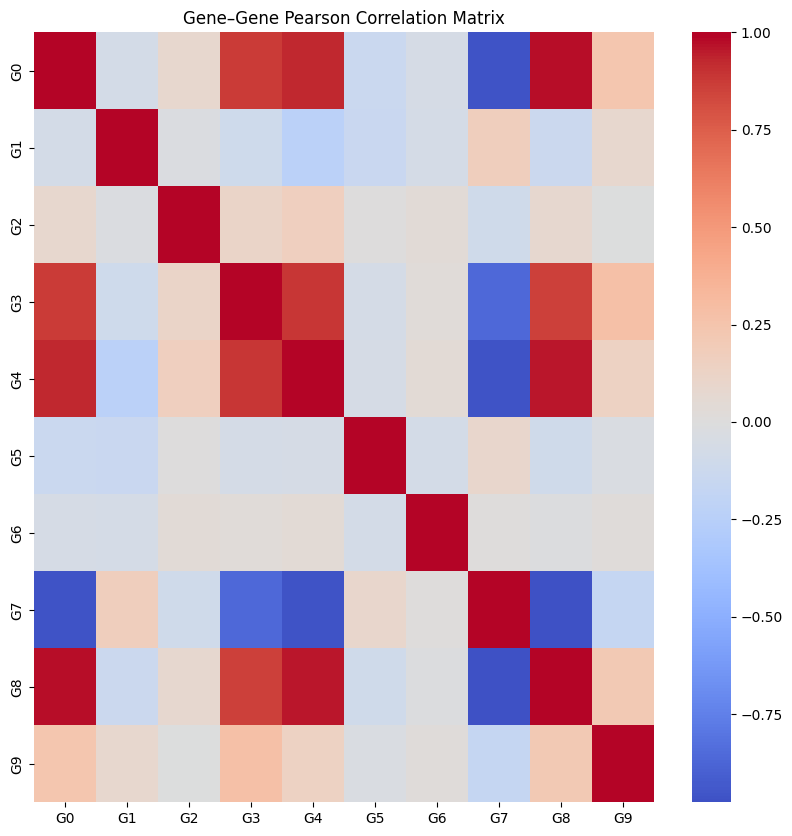

In [20]:
df_expr = pd.DataFrame(X_continuous, columns=[f"G{i}" for i in range(X_continuous.shape[1])])
corr = df_expr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, center=0, cmap="coolwarm")
plt.title("Gene–Gene Pearson Correlation Matrix")
plt.show()

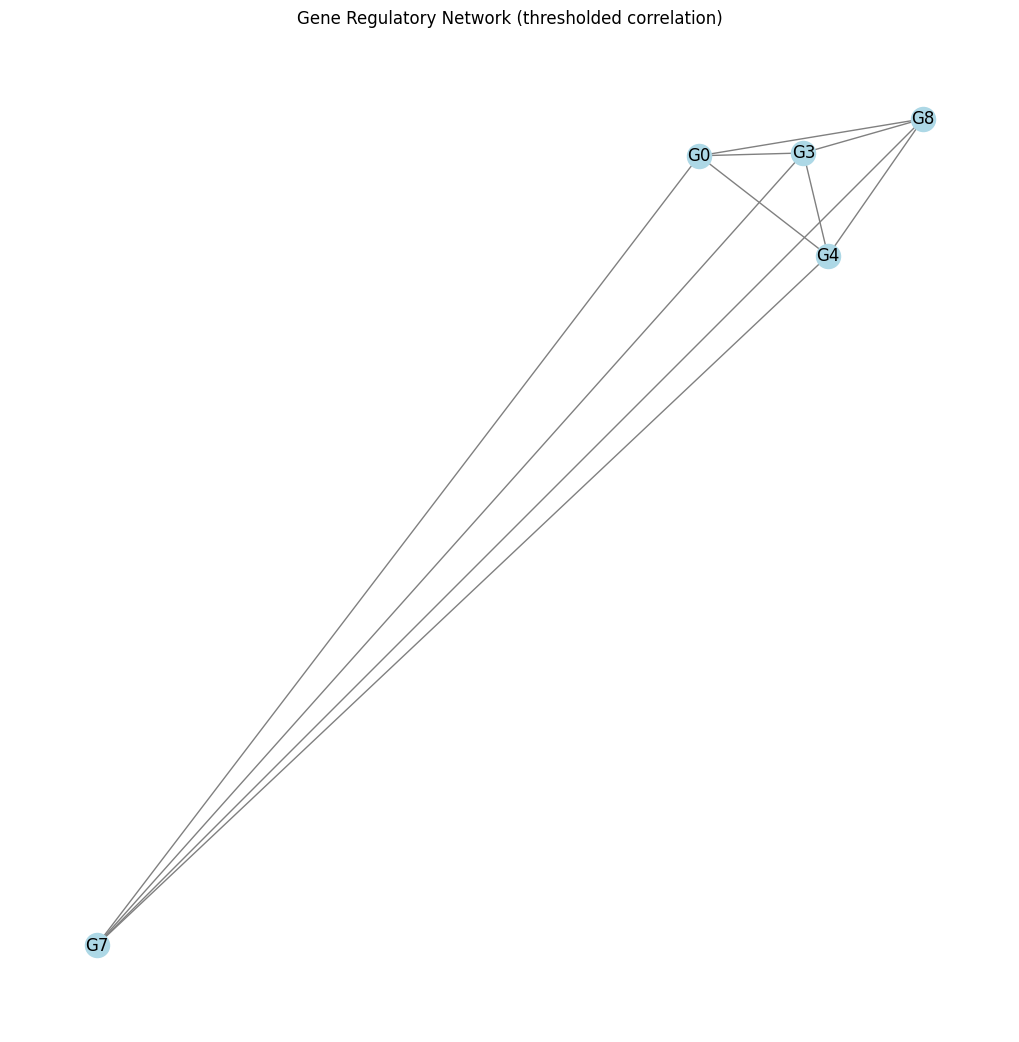

In [21]:
import networkx as nx

G = nx.Graph()

# 閾値以上の相関にエッジを追加（例）
threshold = 0.6
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) > threshold:
            G.add_edge(f"G{i}", f"G{j}", weight=corr.iloc[i, j])

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Gene Regulatory Network (thresholded correlation)")
plt.show()


In [22]:
pd.DataFrame(X_continuous)

,0,1,2,3,4,5,6,7,8,9
0,0.755180,0.972175,0.063880,0.942535,0.532162,0.972276,0.086018,0.137630,0.832154,0.970038
1,0.873027,1.000000,0.080168,0.922074,0.492511,0.980523,0.026730,0.205914,0.933481,0.932389
2,0.857196,0.891390,0.020267,0.923213,0.601850,0.989447,0.096835,0.012037,0.972782,0.945207
3,0.864066,0.969896,0.022800,0.958291,0.511555,0.893697,0.025756,0.073072,0.926704,0.998216
4,0.895792,0.919405,0.042796,0.950656,0.658242,0.994554,0.053045,0.031110,0.980599,0.942957
...,...,...,...,...,...,...,...,...,...,...
995,0.120145,0.978959,0.033778,0.529737,0.089281,0.946812,0.029842,0.976773,0.219359,0.857099
996,0.880471,0.946506,0.043748,0.923403,0.567381,0.929818,0.000000,0.064986,0.936745,0.911491
997,0.843192,0.918858,0.079369,0.914383,0.604247,0.915908,0.040613,0.028619,0.920967,0.925119
998,0.665203,0.936822,0.013248,0.936093,0.485949,0.957925,0.068408,0.218886,0.748592,0.922728


In [23]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
).fit(X_continuous)

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [24]:
embedding_base = reducer.transform(X_continuous)  

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


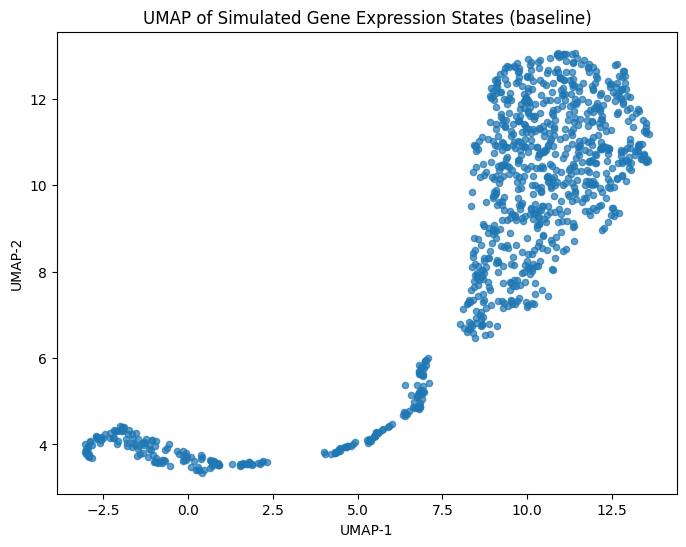

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(embedding_base[:, 0], embedding_base[:, 1], s=20, alpha=0.7)
plt.title("UMAP of Simulated Gene Expression States (baseline)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.show()

In [26]:
W_hat_bag, P_bag = learn_grn_ridge_bagging(X_continuous)

In [27]:
tau = 0.04
active = (np.abs(W_hat_bag) > tau) & (P_bag < 0.05)
W_active = W_hat_bag * active

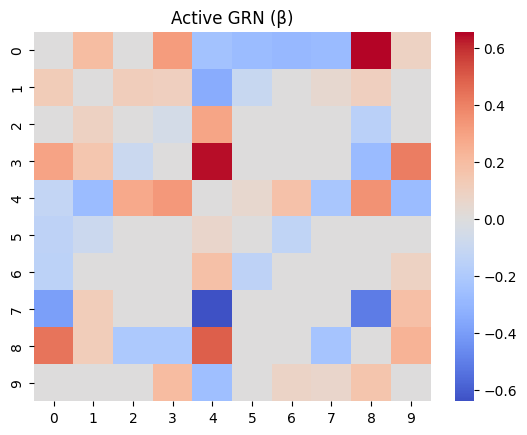

In [28]:
sns.heatmap(W_active, cmap='coolwarm', center=0); plt.title("Active GRN (β)"); plt.show()

In [29]:
# ★ Cell 2 ── β を -1～1 にクリップして発散を防ぐ ★
scale97 = np.quantile(np.abs(W_active[W_active != 0]), 0.97)  # 大きすぎる係数を抑制
W_used  = np.clip(W_active / scale97, -1, 1)                  # -1～1 に正規化

print("max |W_used| =", np.abs(W_used).max().round(3))

max |W_used| = 1.0


In [30]:
# ★ Cell 4 ── Gene 3 を KO して軌跡をチェック ★
pert_gene, mode, n_steps = 3, "KO", 2
x0     = X_continuous.mean(axis=0)                               # 基底ベクトル（平均例）
traj   = simulate_perturbation(x0, W_used, pert_gene, mode, n_steps)

print("traj shape:", traj.shape)                           # (31, genes)
print("  step0  :", traj[0][:5].round(3))                  # 先頭5遺伝子
print("  stepEnd:", traj[-1][:5].round(3))

traj shape: (3, 10)
  step0  : [0.753 0.957 0.044 0.    0.49 ]
  stepEnd: [0.995 0.876 0.314 0.868 0.975]


In [31]:
base2d  = reducer.transform(X_continuous)                       # (cells, 2)
traj2d  = reducer.transform(traj)   

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
from sklearn.neighbors import NearestNeighbors
rng      = np.random.default_rng(0)
k_nn     = 30      # 近傍数
t_len    = 20      # 1 本の歩数
n_walk   = 500     # ランダムウォーク本数

# --- kNN グラフ & 遷移確率行列 P ---------------------------
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(base2d)
dists, idxs = nbrs.kneighbors(base2d)
σ2 = np.median(dists[:,1:]**2)
N  = len(base2d)
P  = np.zeros((N, N))
for i in range(N):
    w   = np.exp(-dists[i,1:]**2 / σ2)           # ガウシアン重み
    P[i, idxs[i,1:]] = w / w.sum()               # 行正規化

# --- 平均行き先ベクトル（drift） --------------------------
end_pos = np.zeros_like(base2d)
for start in range(N):
    for _ in range(n_walk):
        cur = start
        for _ in range(t_len):
            cur = rng.choice(N, p=P[cur])
        end_pos[start] += base2d[cur]
    end_pos[start] /= n_walk

v_ref_MRW = (end_pos - base2d).mean(axis=0)      # ★ これが drift
print("drift_MRW:", v_ref_MRW.round(3))

drift_MRW: [-0.009  0.019]


In [382]:
pd.DataFrame(v_ref_MRW)

,0
0,-0.009267
1,0.019156


Perturbation Score (MRW drift) = 0.527


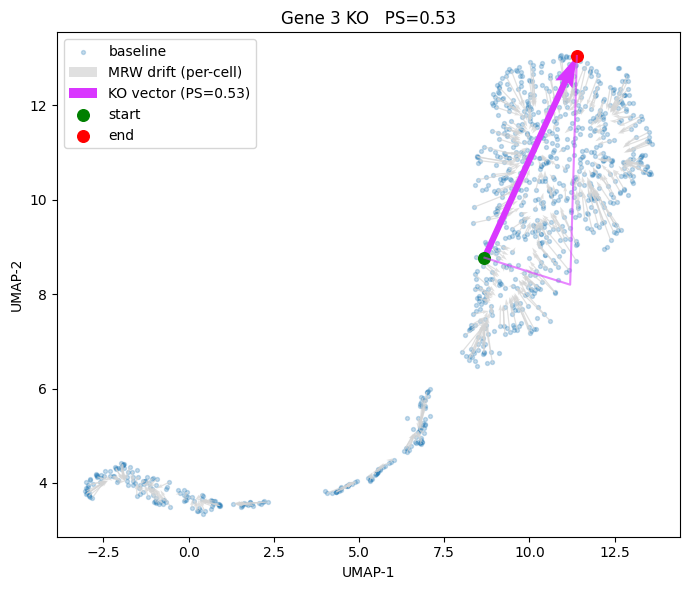

In [33]:
# ---------- 1) PS を計算 -------------------------------------------------
v_ref = v_ref_MRW                                  # 基準 drift (2,)
v_sim = traj2d[-1] - traj2d[0]                     # KO 総移動 (2,)

PS = np.dot(v_ref, v_sim) / (np.linalg.norm(v_ref) * np.linalg.norm(v_sim))
print(f"Perturbation Score (MRW drift) = {PS:.3f}")

# ---------- 2) 矢印の色を PS で決定 (CellOracle: magenta=促進, green=抑制) ----
if   PS >  0: arrow_col = '#d936ff'   # magenta
elif PS <  0: arrow_col = '#3aba36'   # green
else:         arrow_col = 'gray'      # PS≈0

# ---------- 3) 可視化 ----------------------------------------------------
plt.figure(figsize=(7,6))
plt.scatter(base2d[:,0], base2d[:,1], s=8, alpha=0.25, label="baseline")

# ── (i) 全セルの drift フィールド (灰色小矢印) ──────────────────────────
vecs  = end_pos - base2d                             # (N,2)
every = max(1, len(base2d)//400)                    # 高密度なら間引き
plt.quiver(base2d[::every,0], base2d[::every,1],
           vecs[::every,0], vecs[::every,1],
           angles='xy', scale_units='xy', scale=1,
           color='lightgray', alpha=.7, width=0.002,
           label="MRW drift (per-cell)")

# ── (ii) KO ベクトル (PS 色) ────────────────────────────────────────────
plt.quiver(traj2d[0,0], traj2d[0,1],               # 始点 = KO 開始位置
           v_sim[0], v_sim[1],                     # dx, dy
           angles='xy', scale_units='xy', scale=1,
           color=arrow_col, width=0.01,            # ★ PS で色分け
           label=f"KO vector (PS={PS:.2f})")

# ── (iii) 時系列軌跡を薄線で補助的に表示（任意） ─────────────────────
plt.plot(traj2d[:,0], traj2d[:,1], c=arrow_col, lw=1.5, alpha=.6)

# ── (iv) 始点・終点を強調 ────────────────────────────────────────────
plt.scatter(*traj2d[0],  c='green', s=70, label='start')
plt.scatter(*traj2d[-1], c='red',   s=70, label='end')

plt.title(f"Gene {pert_gene} KO   PS={PS:.2f}")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc='best'); plt.tight_layout()


/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

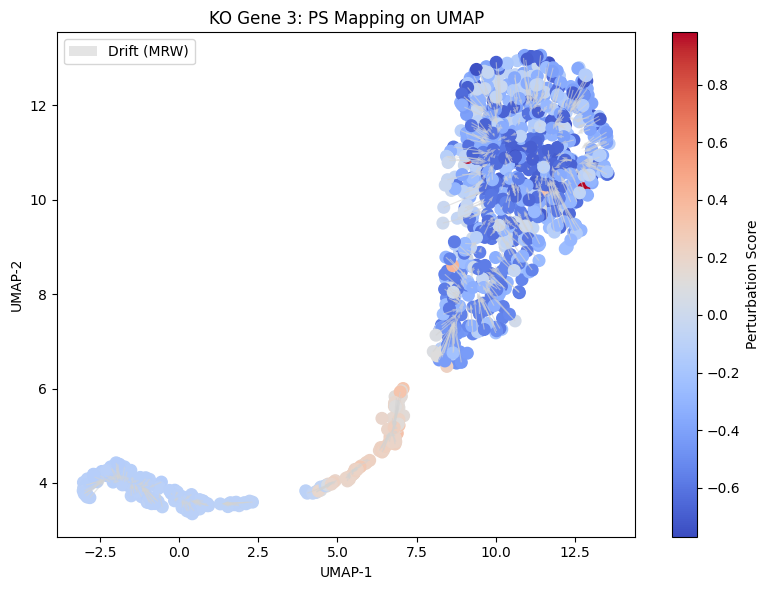

In [ ]:
# === [追加セル] MRW Drift 計算 ===
from sklearn.neighbors import NearestNeighbors
rng = np.random.default_rng(0)
k_nn = 30
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(embedding_base)
dists, idxs = nbrs.kneighbors(embedding_base)
σ2 = np.median(dists[:,1:]**2)
N = len(embedding_base)
P = np.zeros((N, N))
for i in range(N):
    w = np.exp(-dists[i,1:]**2 / σ2)
    P[i, idxs[i,1:]] = w / w.sum()
end_pos = np.zeros_like(embedding_base)
t_len = 20
n_walk = 200
for start in range(N):
    for _ in range(n_walk):
        cur = start
        for _ in range(t_len):
            cur = rng.choice(N, p=P[cur])
        end_pos[start] += embedding_base[cur]
    end_pos[start] /= n_walk
v_ref = (end_pos - embedding_base).mean(axis=0)

# === [追加セル] 全細胞に対するPSスコア計算 ===
ps_scores = []
for i in range(len(X_continuous)):
    x0_i = X_continuous[i]
    traj = simulate_perturbation(x0_i, W_used, pert_gene, mode="KO", n_steps=3)
    traj2d = reducer.transform(traj)
    v_sim = traj2d[-1] - traj2d[0]
    ps = np.dot(v_ref, v_sim) / (np.linalg.norm(v_ref) * np.linalg.norm(v_sim))
    ps_scores.append(ps)

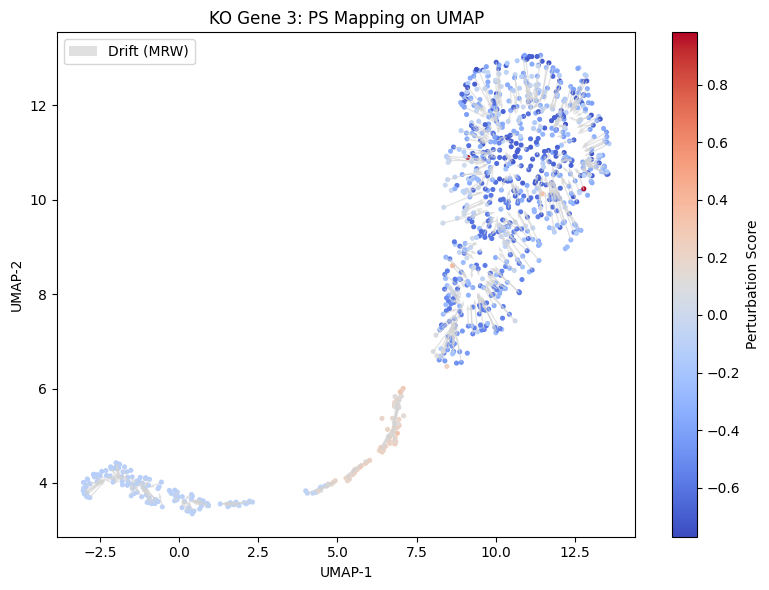

In [61]:
# === [追加セル] PSスコアとdriftの可視化 ===
plt.figure(figsize=(8, 6))
plt.scatter(embedding_base[:,0], embedding_base[:,1], c=ps_scores, cmap="coolwarm", s=7)
plt.colorbar(label="Perturbation Score")

vecs = end_pos - embedding_base
every = max(1, len(embedding_base)//400)
plt.quiver(embedding_base[::every,0], embedding_base[::every,1],
           vecs[::every,0], vecs[::every,1],
           angles='xy', scale_units='xy', scale=1,
           color='lightgray', alpha=.7, width=0.002,
           label="Drift (MRW)")
plt.title(f"KO Gene {pert_gene}: PS Mapping on UMAP")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(loc='best'); plt.tight_layout()

# bayesian retrosynthis

In [103]:
# --- 2. 摂動後の状態をUMAP上に射影する関数 ---
def simulate_to_umap(x0, W, pert_set, reducer, n_steps=3, beta=4.0):
    x = x0.copy()
    for g, mode in pert_set:
        if mode == "KO": x[g] = 0.0
        elif mode == "OE": x[g] = 1.0
        elif isinstance(mode, (float, int)): x[g] = np.clip(x[g] + mode, 0, 1)
    for _ in range(n_steps):
        x = 1 / (1 + np.exp(-beta * (W @ x)))
#    print(reducer.transform([x])[0])
#    print(x)
    return reducer.transform([x])[0],x

In [69]:
# --- 3. 距離にもとづく尤度関数（ガウス核） ---
def likelihood_score(predicted_final, target_state, sigma=0.2):
    d = np.linalg.norm(predicted_final - target_state)
    return np.exp(-d**2 / (2 * sigma**2))


In [96]:
# --- 1. ターゲット状態を定義（UMAP空間上） ---
start_idx, goal_idx = np.random.choice(len(X_continuous), size=2, replace=False)
x_start = X_continuous[start_idx]
x_goal = X_continuous[goal_idx]
umap_start = embedding_base[start_idx]
umap_goal = embedding_base[goal_idx]


In [93]:
x_start

array([0.87228784, 0.9766719 , 0.0397772 , 0.9787983 , 0.60366092,
       0.87887605, 0.05151328, 0.        , 0.99348204, 0.89249639])

In [94]:
x_goal

array([0.89498801, 0.97077507, 0.01357021, 0.94650387, 0.52622703,
       1.        , 0.01551901, 0.14971616, 0.95584887, 0.95252666])

In [97]:
umap_start

array([10.337373, 10.71617 ], dtype=float32)

In [95]:
umap_goal

array([ 8.777513, 10.303911], dtype=float32)

In [98]:
# --- 4. 多様な perturbation セットの構築 ---
n_genes = W_used.shape[0]
perturb_sets = [[(g, "KO")] for g in range(n_genes)] + \
               [[(g, "OE")] for g in range(n_genes)] + \
               [[(g1, "KO"), (g2, "OE")] for g1 in range(n_genes) for g2 in range(n_genes) if g1 != g2]

# 始点と終点を用いた逆合成

In [122]:
trajectory = []
x_current = x_start.copy()
trajectory_umap = [umap_start]
max_steps = 100
tolerance = 0.3

for step in range(max_steps):
    best_score = -np.inf
    best_pert = None
    best_expr = None
    best_umap = None
    for pert_set in perturb_sets:
        try:
            umap_pos, x_new = simulate_to_umap(x_current, W_used, pert_set, reducer)
            score = likelihood_score(umap_pos, umap_goal)
            if score > best_score:
                best_score = score
                best_pert = pert_set
                best_expr = x_new
                best_umap = umap_pos
        except:
            continue

    if best_pert is None:
        print("No valid perturbation found in this step.")
        break

    trajectory.append((best_pert, best_expr, best_umap))
    trajectory_umap.append(best_umap)
    x_current = best_expr.copy()

    if np.linalg.norm(best_umap - umap_goal) < tolerance:
        print(f"Reached target in {step+1} steps.")
        break

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

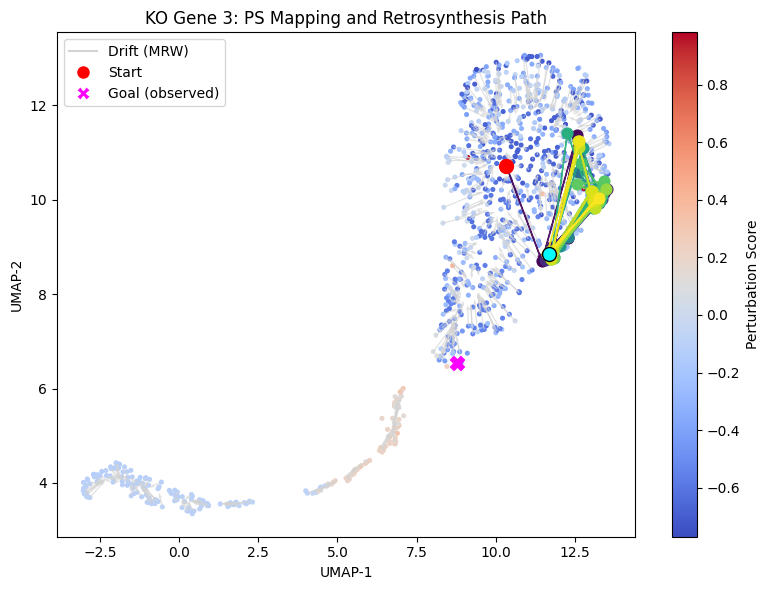

In [123]:
# === [追加セル] PSスコアとdriftの可視化 + Retrosynthesis描画 ===
plt.figure(figsize=(8, 6))
plt.scatter(embedding_base[:,0], embedding_base[:,1], c=ps_scores, cmap="coolwarm", s=7)
plt.colorbar(label="Perturbation Score")

vecs = end_pos - embedding_base
every = max(1, len(embedding_base)//400)
plt.quiver(embedding_base[::every,0], embedding_base[::every,1],
           vecs[::every,0], vecs[::every,1],
           angles='xy', scale_units='xy', scale=1,
           color='lightgray', alpha=.7, width=0.002,
           label="Drift (MRW)")

# --- Retrosynthesis経路を重ね描き ---
colors = plt.cm.viridis(np.linspace(0, 1, len(trajectory_umap)))
for i in range(1, len(trajectory_umap)):
    plt.arrow(trajectory_umap[i-1][0], trajectory_umap[i-1][1],
              trajectory_umap[i][0] - trajectory_umap[i-1][0],
              trajectory_umap[i][1] - trajectory_umap[i-1][1],
              color=colors[i], alpha=0.9, width=0.01, head_width=0.1, length_includes_head=True)
    plt.scatter(*trajectory_umap[i], c=[colors[i]], s=60, label=f"Step {i}")

# Start: 初期細胞
plt.scatter(*trajectory_umap[0], c='red', s=100, label='Start')

# Goal（観測された実際の細胞）
plt.scatter(*umap_goal, c='magenta', s=100, marker='X', label='Goal (observed)')

# 擾乱後のRetrosynthesis最終到達点
plt.scatter(*trajectory_umap[-1], c='cyan', s=100, marker='o', edgecolor='black', label='Final (simulated)')

plt.title(f"KO Gene {pert_gene}: PS Mapping and Retrosynthesis Path")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(handles=[
    plt.Line2D([], [], color='lightgray', label='Drift (MRW)') ,
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Start'),
    plt.Line2D([], [], marker='X', color='w', markerfacecolor='magenta', markersize=10, label='Goal (observed)')
], loc='best')
plt.tight_layout()


# 実装確認

In [300]:
import numpy as np
from numpy.random import default_rng
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import BaggingRegressor
from scipy.stats import t
def learn_grn_ridge_bagging(X_expr: np.ndarray,
                            alpha_grid=None,
                            n_estimators: int = 80,
                            cv: int = 5):
    """
    Bagging(Ridge) による GRN 推定
    ------------------------------------------------------------
    return:
        W_hat : (genes, genes)   … 平均係数
        Pval  : (genes, genes)   … ブートストラップ t 検定の P 値
    """
    n_cells, n_genes = X_expr.shape
    if alpha_grid is None:
        alpha_grid = np.logspace(-2, 2, 8)

    W_hat = np.zeros((n_genes, n_genes))
    Pval  = np.ones_like(W_hat)

    for tgt in range(n_genes):
        mask = np.ones(n_genes, bool); mask[tgt] = False
        X_tf, y = X_expr[:, mask], X_expr[:, tgt]

        # ① α を RidgeCV で最適化
        alpha_opt = RidgeCV(alphas=alpha_grid, cv=cv).fit(X_tf, y).alpha_

        # ② BaggingRegressor(base=Ridge(alpha_opt)) を学習
        base = Ridge(alpha=alpha_opt, fit_intercept=True)
        bag  = BaggingRegressor(estimator=base,
                                n_estimators=n_estimators,
                                bootstrap=True,
                                random_state=0).fit(X_tf, y)

        # ③ 各エスティメータの係数をスタックして統計量を計算
        coefs = np.vstack([est.coef_ for est in bag.estimators_])  # (n_est, n_TF)
        beta_mean = coefs.mean(axis=0)
        beta_se   = coefs.std(axis=0, ddof=1)
        tvals     = np.divide(np.abs(beta_mean), beta_se,
                              out=np.zeros_like(beta_mean), where=beta_se!=0)
        pvals     = 2*(1 - t.cdf(tvals, df=n_estimators-1))

        # ④ 出力行列へ書き込み
        W_hat[tgt, mask] = beta_mean
        Pval [tgt, mask] = pvals

    return W_hat, Pval


In [322]:
W_hat_bag, P_bag = learn_grn_ridge_bagging(X_continuous)

In [323]:
pd.DataFrame(W_hat_bag)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.198966,0.037942,0.319856,-0.240718,-0.271102,-0.288846,-0.279016,0.657649,0.087951
1,0.121140,0.000000,0.111202,0.101653,-0.342708,-0.097817,0.034907,0.050037,0.102662,-0.036459
2,0.019408,0.093294,0.000000,-0.049432,0.289408,-0.011812,-0.032499,0.017461,-0.153240,0.052105
3,0.295495,0.154187,-0.089712,0.000000,0.641936,0.058907,0.037798,0.029553,-0.278786,0.413243
4,-0.117357,-0.270279,0.275025,0.333292,0.000000,0.054855,0.172810,-0.219298,0.351199,-0.269082
5,-0.138244,-0.083929,-0.011083,0.032412,0.060219,0.000000,-0.131396,-0.017157,0.043866,0.041032
6,-0.147047,0.029437,-0.032451,0.020629,0.183613,-0.137448,0.000000,-0.001019,0.010014,0.087033
7,-0.393720,0.120601,0.037663,0.030227,-0.638527,-0.043903,-0.006064,0.000000,-0.510242,0.191701
8,0.435152,0.116429,-0.205245,-0.207278,0.493760,0.060933,0.012066,-0.228522,0.000000,0.238783
9,0.037000,-0.030203,0.049299,0.203180,-0.254731,0.040049,0.078856,0.062294,0.160794,0.000000


In [324]:
pd.DataFrame(P_bag)

,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,9.151847e-07,4.177736e-01,1.998401e-15,3.475750e-07,1.835272e-10,1.110911e-11,0.000000e+00,0.000000e+00,3.276709e-02
1,3.485412e-06,1.000000e+00,2.767495e-03,1.149709e-04,3.945733e-12,2.948775e-03,3.539956e-01,1.515701e-02,6.364446e-04,3.502547e-01
2,4.139078e-01,2.613471e-03,1.000000e+00,9.853855e-03,4.440892e-16,7.260190e-01,3.318734e-01,4.030253e-01,2.910757e-07,9.237188e-02
3,8.415491e-14,6.821128e-05,9.667132e-03,1.000000e+00,0.000000e+00,8.449584e-02,3.695092e-01,2.254646e-01,1.706843e-09,4.849232e-12
4,5.808939e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.178435e-02,2.154730e-08,0.000000e+00,0.000000e+00,3.270939e-12
5,1.203260e-11,1.185270e-03,7.371979e-01,7.270727e-02,1.744072e-02,1.000000e+00,7.385363e-06,3.021419e-01,8.318943e-02,1.763518e-01
6,3.772471e-11,3.527225e-01,3.332596e-01,3.716302e-01,2.550854e-07,1.026624e-05,1.000000e+00,9.512774e-01,6.677980e-01,4.379593e-03
7,0.000000e+00,7.253979e-03,4.790875e-01,3.813819e-01,0.000000e+00,3.015421e-01,8.864225e-01,1.000000e+00,0.000000e+00,3.129309e-04
8,0.000000e+00,4.366305e-04,1.694033e-07,1.487006e-10,0.000000e+00,7.728802e-02,7.014658e-01,1.110223e-15,1.000000e+00,1.049207e-07
9,4.347134e-02,3.071199e-01,8.042528e-02,4.440892e-16,1.284817e-11,1.786586e-01,3.237574e-03,1.170240e-03,1.661352e-07,1.000000e+00


In [325]:
tau = 0.04
active = (np.abs(W_hat_bag) > tau) & (P_bag < 0.05)
W_active = W_hat_bag * active

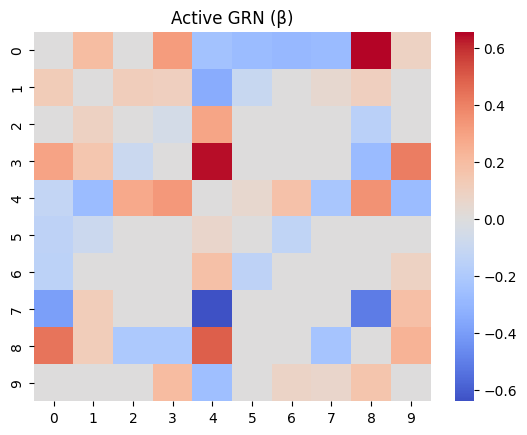

In [326]:
sns.heatmap(W_active, cmap='coolwarm', center=0); plt.title("Active GRN (β)"); plt.show()

In [327]:
# ★ Cell 2 ── β を -1～1 にクリップして発散を防ぐ ★
scale97 = np.quantile(np.abs(W_active[W_active != 0]), 0.97)  # 大きすぎる係数を抑制
W_used  = np.clip(W_active / scale97, -1, 1)                  # -1～1 に正規化

print("max |W_used| =", np.abs(W_used).max().round(3))

max |W_used| = 1.0


In [328]:
# ★ Cell 3 ── propagate と simulate_perturbation 定義 ★
def sigmoid(z, beta=4.0):
    return 1 / (1 + np.exp(-beta * z))

def propagate(x, W, beta=4.0):
    return np.clip(sigmoid(W @ x, beta), 0, 1)                # 1 step

def simulate_perturbation(x0, W, g, mode="KO", n_steps=30, beta=4.0):
    x = x0.copy()
    if mode == "KO":  x[g] = 0.0
    elif mode == "OE": x[g] = 1.0
    else:             x[g] = np.clip(x[g] + mode, 0, 1)

    traj = np.zeros((n_steps+1, len(x)))
    traj[0] = x                                              # step 0
    for t in range(1, n_steps+1):
        x = propagate(x, W, beta)                            # 下流へ伝播
        traj[t] = x
    return traj                                              # (n_steps+1, genes)


In [336]:
# ★ Cell 4 ── Gene 3 を KO して軌跡をチェック ★
pert_gene, mode, n_steps = 3, "KO", 3
x0     = X_base.mean(axis=0)                               # 基底ベクトル（平均例）
traj   = simulate_perturbation(x0, W_used, pert_gene, mode, n_steps)

print("traj shape:", traj.shape)                           # (31, genes)
print("  step0  :", traj[0][:5].round(3))                  # 先頭5遺伝子
print("  stepEnd:", traj[-1][:5].round(3))


traj shape: (4, 10)
  step0  : [0.922 0.599 0.698 0.    0.869]
  stepEnd: [0.987 0.534 0.721 0.998 0.928]


In [337]:
pd.DataFrame(traj)

,0,1,2,3,4,5,6,7,8,9
0,0.921653,0.598893,0.698085,0.000000,0.868846,0.354229,0.568067,0.052201,0.936403,0.777349
1,0.868988,0.431023,0.735921,0.996800,0.715985,0.222504,0.566803,0.000645,0.997038,0.464547
2,0.986533,0.684329,0.570474,0.980831,0.983283,0.236133,0.521147,0.000675,0.965994,0.803575
3,0.986566,0.534008,0.721165,0.998483,0.928130,0.219184,0.612161,0.000349,0.995576,0.712756


In [338]:
pd.DataFrame(traj[0][:5])

,0
0,0.921653
1,0.598893
2,0.698085
3,0.000000
4,0.868846


In [341]:
# ★ Cell 5 ── UMAP 空間でベクトル比較 → PS ★
import umap
reducer = umap.UMAP(random_state=0).fit(X_base)            # 基底のみで学習
base2d  = reducer.transform(X_base)                        # (cells, 2)
traj2d  = reducer.transform(traj)                          # (31, 2)

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [342]:
from sklearn.neighbors import NearestNeighbors
rng      = np.random.default_rng(0)
k_nn     = 30      # 近傍数
t_len    = 20      # 1 本の歩数
n_walk   = 500     # ランダムウォーク本数

# --- kNN グラフ & 遷移確率行列 P ---------------------------
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(base2d)
dists, idxs = nbrs.kneighbors(base2d)
σ2 = np.median(dists[:,1:]**2)
N  = len(base2d)
P  = np.zeros((N, N))
for i in range(N):
    w   = np.exp(-dists[i,1:]**2 / σ2)           # ガウシアン重み
    P[i, idxs[i,1:]] = w / w.sum()               # 行正規化

# --- 平均行き先ベクトル（drift） --------------------------
end_pos = np.zeros_like(base2d)
for start in range(N):
    for _ in range(n_walk):
        cur = start
        for _ in range(t_len):
            cur = rng.choice(N, p=P[cur])
        end_pos[start] += base2d[cur]
    end_pos[start] /= n_walk

v_ref_MRW = (end_pos - base2d).mean(axis=0)      # ★ これが drift
print("drift_MRW:", v_ref_MRW.round(3))


drift_MRW: [-0.001 -0.   ]


Perturbation Score (MRW drift) = 0.995


/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


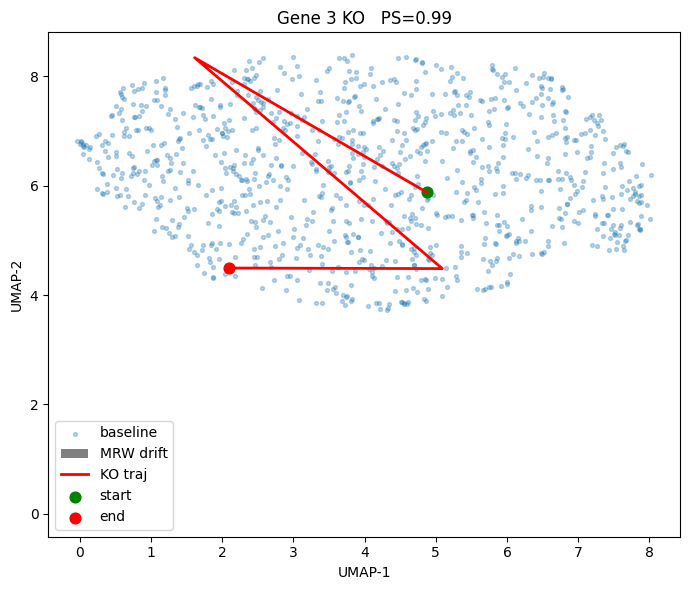

In [343]:
traj2d = reducer.transform(traj)                 # (n_steps+1, 2)

v_ref = v_ref_MRW                                # ← 置き換えポイント
v_sim = traj2d[-1] - traj2d[0]

PS = np.dot(v_ref, v_sim) / (np.linalg.norm(v_ref) * np.linalg.norm(v_sim))
print(f"Perturbation Score (MRW drift) = {PS:.3f}")

# ------- plot -------
plt.figure(figsize=(7,6))
plt.scatter(base2d[:,0], base2d[:,1], s=8, alpha=0.3, label="baseline")
plt.quiver(0, 0, *v_ref, color='gray', scale_units='xy',
           scale=1, width=0.004, label="MRW drift")
plt.plot(traj2d[:,0], traj2d[:,1], c='red', lw=2, label='KO traj')
plt.scatter(*traj2d[0],  c='green', s=60, label='start')
plt.scatter(*traj2d[-1], c='red',   s=60, label='end')
plt.title(f"Gene {pert_gene} KO   PS={PS:.2f}")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.legend(); plt.tight_layout()


In [344]:
## 線形伝搬器の具体例

In [311]:
import numpy as np

# 3 遺伝子の簡易 GRN (ターゲット←TF) 係数
W = np.array([[ 0, 0.7, 0.0],
              [-0.4, 0, 0.3],
              [ 0.2, 0, 0  ]])

x0   = np.array([0.8, 0.6, 0.4])    # 初期発現
delta = np.zeros_like(x0)
delta[1] = -0.6                     # Gene-1 KO (OEなら +0.4 など)

# 1 hop 伝搬
delta_1 = W @ delta                 # 直接標的への影響
# 2 hop
delta_2 = W @ delta_1               # 間接標的への影響
pd.DataFrame(delta)

,0
0,0.0
1,-0.6
2,0.0


In [315]:
pd.DataFrame(W)

,0,1,2
0,0.0,0.7,0.0
1,-0.4,0.0,0.3
2,0.2,0.0,0.0


In [313]:
pd.DataFrame(x0)

,0
0,0.8
1,0.6
2,0.4


In [310]:
print("1 hop Δ:", delta_1.round(3))
print("2 hop Δ:", delta_2.round(3))

1 hop Δ: [-0.42  0.    0.  ]
2 hop Δ: [ 0.     0.168 -0.084]


In [345]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 4 つの細胞クラスタを 2D に配置（UMAP 後の座標を想定）
base2d = np.array([[0.1, 0.2],      # Cell-0 (幹に近い?)
                   [0.2, 0.1],      # Cell-1
                   [1.0, 0.9],      # Cell-2 (分化末端)
                   [1.1, 1.0]])     # Cell-3

N = len(base2d)

In [346]:
base2d

array([[0.1, 0.2],
       [0.2, 0.1],
       [1. , 0.9],
       [1.1, 1. ]])

In [347]:
N

4

In [348]:
k = 3                                                 # 近傍数
nbrs  = NearestNeighbors(n_neighbors=k).fit(base2d)
dists, idxs = nbrs.kneighbors(base2d)                 # 各セルの近傍 index

sigma2 = np.median(dists[:,1:]**2)                    # ガウスカーネルの幅
P = np.zeros((N, N))                                  # 転移確率行列
for i in range(N):
    weights = np.exp(-dists[i,1:]**2 / sigma2)        # 近いほど高確率
    P[i, idxs[i,1:]] = weights / weights.sum()        # 行正規化

print("Transition matrix P\n", P)


Transition matrix P
 [[0.         0.87752847 0.12247153 0.        ]
 [0.87418303 0.         0.12581697 0.        ]
 [0.         0.12581697 0.         0.87418303]
 [0.         0.07859885 0.92140115 0.        ]]


In [349]:
pd.DataFrame(P)

,0,1,2,3
0,0.000000,0.877528,0.122472,0.000000
1,0.874183,0.000000,0.125817,0.000000
2,0.000000,0.125817,0.000000,0.874183
3,0.000000,0.078599,0.921401,0.000000


In [350]:
rng     = np.random.default_rng(0)
n_walk  = 200         # 1 セルあたり何本発射するか
t_len   = 15          # 1 本が何ステップ進むか
end_pos = np.zeros_like(base2d)

for start in range(N):
    ends = []
    for _ in range(n_walk):
        cur = start
        for _ in range(t_len):
            cur = rng.choice(N, p=P[cur])             # P の行を使い遷移
        ends.append(base2d[cur])
    end_pos[start] = np.mean(ends, axis=0)            # 行き先平均

drift = (end_pos - base2d).mean(axis=0)               # ★ ベクトル場の平均
print("Drift vector =", drift.round(3))

Drift vector = [0.028 0.024]


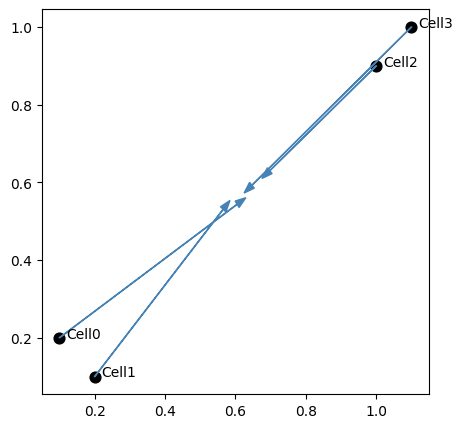

In [351]:
plt.figure(figsize=(5,5))
plt.scatter(base2d[:,0], base2d[:,1], c="black", s=60)
for i,pos in enumerate(base2d):
    plt.text(pos[0]+0.02, pos[1], f"Cell{i}")

# 各セル→平均行き先を矢印で描く
for i in range(N):
    vec = end_pos[i] - base2d[i]
    plt.arrow(base2d[i,0], base2d[i,1],
              vec[0], vec[1],
              head_width=0.02, color="steelblue", length_includes_head=True)


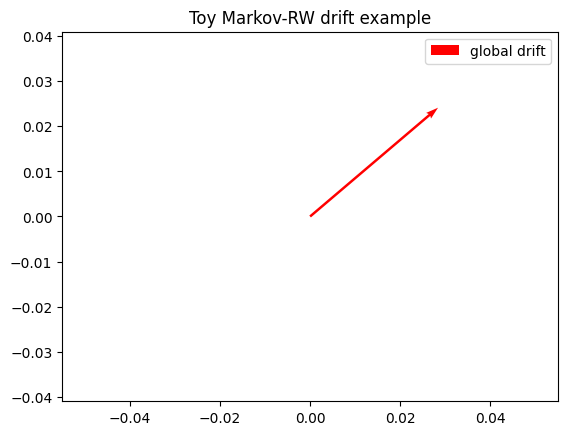

In [352]:
# 全セル平均 drift を原点から描く
plt.quiver(0,0, drift[0], drift[1],
           angles="xy", scale_units="xy", scale=1,
           color="red", width=0.005, label="global drift")

plt.legend(); plt.title("Toy Markov-RW drift example")
plt.axis("equal"); plt.show()